In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from librep.datasets.har.loaders import (
    MotionSense_BalancedView20HZ
)

2022-11-08 13:39:55.412420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-08 13:39:55.412440: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *

In [6]:
# MotionSense Loader
loader = MotionSense_BalancedView20HZ(
    root_dir="../../../data/views/MotionSense/balanced_view_20Hz_with_gravity_9.81_acc_standard", 
    download=False
)

# Print the readme (optional)
loader.print_readme()

# Balanced MotionSense View Resampled to 20Hz with Gravity - Multiplied acc by 9.81m/s²

This is a view from [MotionSense] that was spllited into 3s windows and was resampled to 20Hz using the [FFT method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample). 

The data was first splitted in three sets: train, validation and test. Each one with the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

**NOTE**: Each subset contain samples from distinct users, that is, samples of one user belongs exclusivelly to one of three subsets.

## Activity codes
- 0: downstairs (569 train, 101 validation, 170 test) 
- 1: upstairs (569 train, 101 validation, 170 test) 
- 2: sitting (569 train, 101 validation, 170 test) 
- 3: standing (569 train, 101 validation, 170 test) 
- 4: walking (569 train, 101 validation, 170 test) 
- 5: jogging (569 train, 101 validation, 170 test) 
 

## Standartized activity codes
- 0: sit (569 train, 101 validation, 170 test) 
- 1: stand (569 train, 101 validation, 170 test) 
- 2: walk (569 train, 101 validation, 170 test) 
- 3: stair up (569 train, 101 validation, 170 test) 
- 4: stair down (569 train, 101 validation, 170 test) 
- 5: run (569 train, 101 validation, 170 test) 
      




In [7]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [8]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [9]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 360) (4020,) (1020, 360) (1020,)


# Aplicar FFT

In [10]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [11]:
train_dataset_fft = transformer(train_val)
# validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test)

In [12]:
print(train_dataset_fft.X.shape)
# print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(4020, 180)
(1020, 180)


In [13]:
print(np.max(train_dataset_fft.X))

797.3368276806895


In [14]:
train_dataset_fft.X

array([[117.47446671,   7.69616708,   9.12345317, ...,   1.58565333,
          1.92709353,   2.56103481],
       [ 56.99305528,   7.03810632,  21.13174295, ...,   3.59397955,
          1.24491107,   2.19807336],
       [ 43.67148129,   9.31303897,  48.54955013, ...,   0.20668447,
          2.1782541 ,   1.17453151],
       ...,
       [ 48.49117037,   5.91621941,  13.46303591, ...,   0.95960646,
          3.65355504,   4.60541355],
       [ 88.69039888,  27.8862055 ,  19.11225658, ...,   1.48263297,
          3.9119881 ,   2.55326373],
       [ 55.520648  ,   2.58290685,   8.95693627, ...,   5.4340967 ,
          4.2408613 ,  10.63953696]])

In [15]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

In [16]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 180) (4020,) (1020, 180) (1020,)


# Visualization helper

In [17]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    # ax.legend()
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Computing Accuracy and F1 values over high dimensionality

In [18]:
experiments_result = run_experiments(None, train_HD, train_Y, None, test_HD, test_Y)
experiments_result

{'RF-ACC': 0.8762745098039216,
 'RF-F1': 0.8718135545594968,
 'SVC-ACC': 0.9068627450980392,
 'SVC-F1': 0.9088525697119879,
 'KNN-ACC': 0.8470588235294118,
 'KNN-F1': 0.84669223262764}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


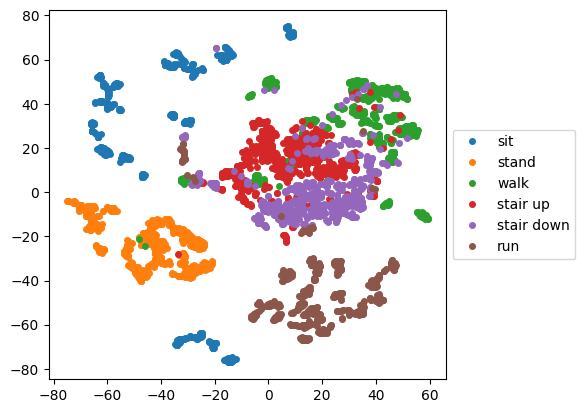

In [19]:
# Visualizing train
tsne = TSNE()
train_2D = tsne.fit_transform(train_HD)
visualize(train_2D, train_Y)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


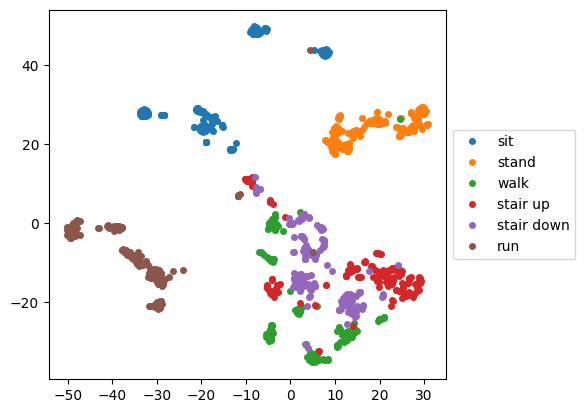

In [20]:
# Visualizing test
tsne = TSNE()
test_2D = tsne.fit_transform(test_HD)
visualize(test_2D, test_Y)

# Variables to reuse

In [21]:
dim_to_reduce = 10

# Reducing with UMAP

In [22]:
umap_reducer = UMAP(n_components=dim_to_reduce)
umap_reducer.fit(train_HD, train_Y)

UMAP(n_components=10, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [23]:
train_LD = umap_reducer.transform(train_HD)
test_LD = umap_reducer.transform(test_HD)

In [24]:
train_LD = np.reshape(umap_reducer.transform(train_HD), (-1, dim_to_reduce))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(umap_reducer.transform(test_HD), (-1, dim_to_reduce))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [25]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8653921568627452,
 'RF-F1': 0.8653075816076292,
 'SVC-ACC': 0.8607843137254902,
 'SVC-F1': 0.8613554579582314,
 'KNN-ACC': 0.8715686274509804,
 'KNN-F1': 0.8715492330321697}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


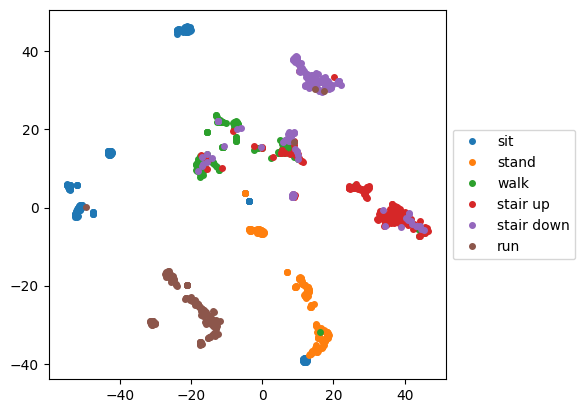

In [26]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)